# PyVWF: Running multiple scenarios and plotting

This notebook exists for research purposes to easily run and compare all the various variations of this model:
- How spatial (no. of clusters) and temporal (from yearly to monthly) 

This code can take a long time to run as training needs to occur dependent on number of clusters.

In [1]:
import vwf.VWF_Model as model

In [2]:
time_res_list = ['yearly', 'season', 'bimonth', 'month']

# cluster_list = [1,10,100,500,700]
cluster_list = [1,5,10,50,100,500,600,700,800,900,1000,2000,3000,3700]
country = "DK"
year_test = 2020 # year you wish to receive a time series for

# cluster_list = [1,10,100,250,500,600]
# country = "DE"
# year_test = 2019 # year you wish to receive a time series for

In [3]:
vwf_model = model.VWF(country, cluster_list, time_res_list)

In [4]:
vwf_model.train()

Total observed turbines/farms before conditions:  5623
Number of valid observed turbines/farms:  3707
Training for  1  clusters with time resolution:  yearly  is already trained!
 
Training for  1  clusters with time resolution:  season  is already trained!
 
Training for  1  clusters with time resolution:  bimonth  is already trained!
 
Training for  1  clusters with time resolution:  month  is already trained!
 
Training for  5  clusters with time resolution:  yearly  is already trained!
 
Training for  5  clusters with time resolution:  season  is already trained!
 
Training for  5  clusters with time resolution:  bimonth  is already trained!
 
Training for  5  clusters with time resolution:  month  is already trained!
 
Training for  10  clusters with time resolution:  yearly  is already trained!
 
Training for  10  clusters with time resolution:  season  is already trained!
 
Training for  10  clusters with time resolution:  bimonth  is already trained!
 
Training for  10  cluster

In [5]:
# vwf_model.test(year_test)
vwf_model.train_check()

Total observed turbines/farms before conditions:  5623
Number of valid observed turbines/farms:  3707
Test for  1  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 10.49 seconds
 
Test for  1  clusters with time resolution:  season  is taking place.
Results completed and saved. Elapsed time: 10.71 seconds
 
Test for  1  clusters with time resolution:  bimonth  is taking place.
Results completed and saved. Elapsed time: 10.81 seconds
 
Test for  1  clusters with time resolution:  month  is taking place.
Results completed and saved. Elapsed time: 10.40 seconds
 
Test for  5  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 10.88 seconds
 
Test for  5  clusters with time resolution:  season  is taking place.
Results completed and saved. Elapsed time: 10.83 seconds
 
Test for  5  clusters with time resolution:  bimonth  is taking place.
Results completed and saved. Elapsed time: 10.53 seco

In [6]:
# # running for merra

# vwf_model = model.VWF(country, year_star, year_end, year_test)
# vwf_model.test_merra(time_res)

In [7]:
# import time
# import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from vwf.extras import calc_metrics_era5
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib

bg_colour = '#f0f0f0'
custom_params = {'xtick.bottom': True, 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'axes.facecolor': bg_colour}
sns.set_theme(style='darkgrid', rc=custom_params)

In [8]:
clus_metrics, month_metrics  = calc_metrics_era5(year_test, country, cluster_list, time_res_list) 

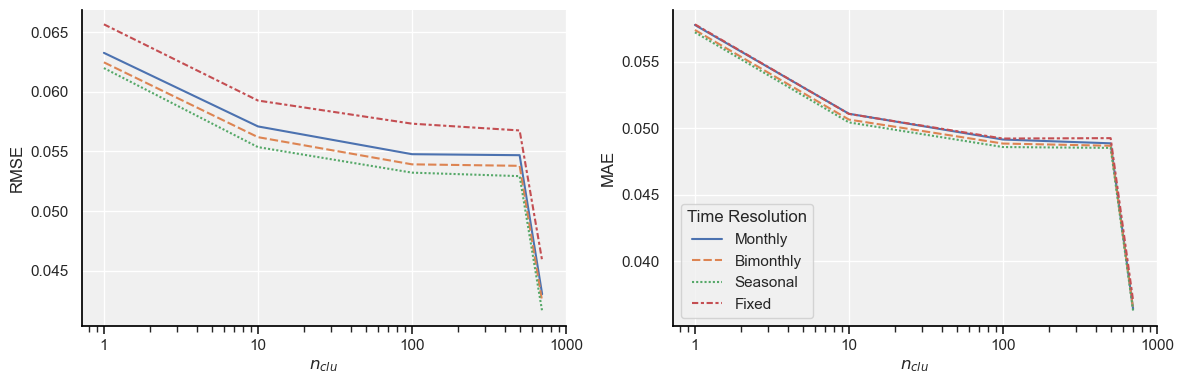

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    x='num_clu',
    y='RMSE',
    hue ="time_res",
    style="time_res",
    hue_order = ['month', 'bimonth', 'season', 'yearly'],
    style_order= ['month', 'bimonth', 'season', 'yearly'],
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[0],
    legend = False
)
axes[0].set_xscale('log')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('$n_{clu}$')
axes[0].set_xticks([1, 10, 100,1000])
axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.lineplot(
    x='num_clu',
    y='MAE',
    hue ="time_res",
    style= "time_res",
    hue_order = ['month', 'bimonth', 'season', 'yearly'],
    style_order= ['month', 'bimonth', 'season', 'yearly'],
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[1],
    legend = True
)

axes[1].set_xscale('log')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('$n_{clu}$')
axes[1].set_xticks([1, 10, 100,1000])
axes[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fixing the legend labels and sharing it over whole plot.
axes[1].get_legend().remove()
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Monthly', 'Bimonthly',  'Seasonal', 'Fixed'] # renaming labels
plt.legend(handles, labels, ncol=1, loc='lower left', title='Time Resolution')
plt.savefig("data/plots/"+country+"_full_error.png", bbox_inches='tight')
plt.tight_layout()

In [ ]:
def calc_regional_error2(df_sim, df_obs, turb_info):
    df_obs['time'] = pd.to_datetime(df_obs['time'])
    df_obs['month'] = df_obs.time.dt.month
    df_obs_monthly = df_obs.drop(columns=['time']).set_index('month').reset_index()
    df_obs_monthly = df_obs_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')
    
    df_sim['time'] = pd.to_datetime(df_sim['time'])
    df_sim['month'] = df_sim.time.dt.month
    df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean().reset_index()
    df_sim_monthly = df_sim_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')

    turb_info['ID'] = turb_info['ID'].apply(str)
    
    merged = pd.merge(df_sim_monthly, df_obs_monthly, on=['ID', 'month'], suffixes=('_sim', '_obs'))
    merged = pd.merge(merged, turb_info[['ID', 'capacity','region']], on='ID')
    
    merged['diff'] = merged['cf_obs'] - merged['cf_sim']
    merged['abdiff'] = np.abs(merged['diff'])
    merged['sqdiff'] = merged['diff']**2
    
    merged = merged.dropna(subset=['cf_sim', 'cf_obs', 'capacity'])

    def weighted_avg(df, values, weights):
        return (df[values] * df[weights]).sum() / df[weights].sum()

    wavg = lambda x: weighted_avg(merged.loc[x.index], 'sqdiff', 'capacity')
    wavg2 = lambda x: weighted_avg(merged.loc[x.index], 'abdiff', 'capacity')
    wavg3 = lambda x: weighted_avg(merged.loc[x.index], 'cf_obs', 'capacity')

    error = merged.groupby('region').agg({"sqdiff": wavg, 'abdiff': wavg2, 'cf_obs': wavg3})

    rmse = (np.sqrt(error['sqdiff'])/error['cf_obs']).rename('rmse')
    mae = (error['abdiff']/error['cf_obs']).rename('mae')

    return rmse, mae


def test_regional_error(run, year_test, country, turb_info, cluster_list, time_res_list=['yearly', 'season', 'bimonth', 'month']):
    rmse_all = []
    mae_all = []
    cluster_all = []
    time_all = []
    regional_all = []

    obs_cf = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
    unc_cf = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
    rmse, mae = calc_regional_error2(unc_cf, obs_cf, turb_info)

    rmse_all.append(rmse)
    mae_all.append(mae)
    cluster_all.append([1]*len(rmse))
    time_all.append(['uncorrected']*len(rmse))
    regional_all.append(rmse.index)
    
    for num_clu in cluster_list:
        for time_res in time_res_list:
            cor_cf = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
            rmse, mae = calc_regional_error2(cor_cf, obs_cf, turb_info)
            
            rmse_all.append(rmse)
            mae_all.append(mae)
            cluster_all.append([num_clu]*len(rmse))
            time_all.append([time_res]*len(rmse))
            regional_all.append(rmse.index)
    
    
    df_metrics = pd.DataFrame(list(zip(np.ravel(regional_all), np.ravel(cluster_all), np.ravel(time_all), np.ravel(rmse_all), np.ravel(mae_all))), 
                 columns =['region','num_clu', 'time_res', 'rmse', 'mae'])

    return df_metrics


def plot_regional_error(run, df_metrics, name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    sns.lineplot(
        x='region',y='rmse',
        data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == 1) | (df_metrics['num_clu'] == 500) | (df_metrics['num_clu'] == 3000))],
        hue ="num_clu",style="time_res",palette="tab10",
        ax = axes[0],
        legend = False
    )
    axes[0].set_ylabel('RMSE')
    axes[0].set_xlabel('Region')
    
    sns.lineplot(
        x='region',y='mae',
        data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == 1) | (df_metrics['num_clu'] == 500) | (df_metrics['num_clu'] == 3000))],
        hue ="num_clu",style="time_res",palette="tab10",
        ax = axes[1],
        legend = True
    )
    
    axes[1].set_ylabel('MAE')
    axes[1].set_xlabel('Region')
    
    # fixing the legend labels and sharing it over whole plot.
    axes[1].get_legend().remove()
    handles, labels = plt.gca().get_legend_handles_labels()
    print(labels)
    labels = ['$n_{clu}$', '1', '500','3000', '$t_{freq}$', 'Fixed', 'Seasonal']
    plt.legend(handles, labels, ncol=1, loc='right', bbox_to_anchor=(1.3, 0.5))
    plt.tight_layout()
    # plt.savefig(run+'/plots/'+country+'_'+name+'_error.png', bbox_inches='tight')
    return plt.tight_layout()